In [1]:
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

In [2]:
#access data from city of chicago API and convert request data to pandas dataframe

In [3]:
#get 2017 and 2018 crime data
client = Socrata("data.cityofchicago.org", "HfV6h8Xj9GdgDGkPS9JEkKvlp")
crimes_id = "6zsd-86xi"
response_crimes = client.get(crimes_id, where="year between 2017 and 2018", limit=800000)
crimes_2017_2018_df = pd.DataFrame.from_records(response_crimes)

In [4]:
#get community area name data
community_area_id = "igwz-8jzy"
response_cas = client.get(community_area_id)
community_areas_df = pd.DataFrame.from_records(response_cas)
community_areas_df['community_area'] = community_areas_df['area_num_1']
community_areas_to_merge = community_areas_df[['community_area', 'community']]

In [5]:
#merging in community area names
crime_with_cas = pd.merge(crimes_2017_2018_df, community_areas_to_merge, on="community_area")
#checking NAs in variables
crime_with_cas.isna().any()

arrest                  False
beat                    False
block                   False
case_number             False
community_area          False
date                    False
description             False
district                 True
domestic                False
fbi_code                False
id                      False
iucr                    False
latitude                 True
location                 True
location_description     True
longitude                True
primary_type            False
updated_on              False
ward                     True
x_coordinate             True
y_coordinate             True
year                    False
community               False
dtype: bool

Question 1

In [6]:
#since there are no NAs in the primary type variable I can use size to determine the counts
crime_by_type = crime_with_cas.groupby('primary_type').size().reset_index(name="count")
crime_by_type['percent'] = crime_by_type['count']/len(crime_with_cas)
crime_by_type.sort_values(by = 'percent', ascending=False)

,primary_type,count,percent
30,THEFT,129428,0.242207
2,BATTERY,98994,0.185254
6,CRIMINAL DAMAGE,56848,0.106383
1,ASSAULT,39678,0.074252
8,DECEPTIVE PRACTICE,37764,0.070670
23,OTHER OFFENSE,34357,0.064295
3,BURGLARY,24730,0.046279
17,NARCOTICS,24645,0.046120
27,ROBBERY,21559,0.040345
16,MOTOR VEHICLE THEFT,21394,0.040036


In [7]:
crime_overall = crime_with_cas.groupby('year').size().reset_index(name="n_crimes")
crime_overall

,year,n_crimes
0,2017,268095
1,2018,266274


In [8]:
crime_type_by_year = crime_with_cas.groupby(['year', 'primary_type']).agg({'primary_type':'count'}).unstack(level=0).reset_index(level=0)
crime_type_by_year.columns = crime_type_by_year.columns.get_level_values(1)
crime_type_by_year['pct_change'] = (crime_type_by_year['2018'] - crime_type_by_year['2017'])/(crime_type_by_year['2017'])
crime_type_by_year.sort_values(by='pct_change', ascending=False)

year,,2017,2018,pct_change
4,CONCEALED CARRY LICENSE VIOLATION,69,149,1.159420
11,HUMAN TRAFFICKING,9,14,0.555556
19,NON-CRIMINAL (SUBJECT SPECIFIED),2,3,0.500000
15,LIQUOR LAW VIOLATION,191,268,0.403141
25,PUBLIC INDECENCY,10,14,0.400000
12,INTERFERENCE WITH PUBLIC OFFICER,1086,1305,0.201657
31,WEAPONS VIOLATION,4686,5450,0.163039
17,NARCOTICS,11658,12987,0.113999
13,INTIMIDATION,151,168,0.112583
29,STALKING,188,203,0.079787


In [9]:
#how seasonal are crimes? has the crime rate gone down over time?

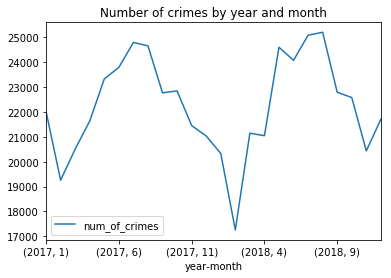

In [10]:
tf = crime_with_cas.groupby([pd.to_datetime(crime_with_cas['date']).dt.month, 'year']).size()
tf = tf.to_frame().reset_index()
tf.columns = ['month', 'year', 'num_of_crimes']
tf['year-month'] = list(zip(tf.year, tf.month))
tf = tf.sort_values(by=['year-month'])
tf.plot(x='year-month', y='num_of_crimes', kind="line", title= "Number of crimes by year and month")

In [11]:
#what percentage of crimes result in an arrest?

arrest
False    0.80357
True     0.19643
dtype: float64

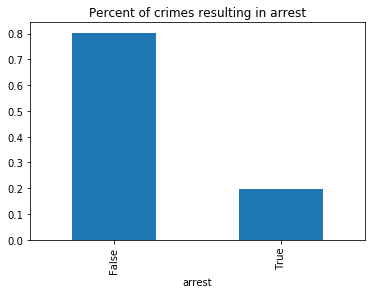

In [12]:
grouped_arrest = crime_with_cas.groupby('arrest').size()/len(crime_with_cas)
grouped_arrest.plot(kind='bar', title= "Percent of crimes resulting in arrest")
grouped_arrest

In [13]:
#how do the number of crimes differ by community area?

In [14]:
crime_by_area = crime_with_cas.groupby('community').size().reset_index(name="count")
crime_by_area['percent'] = crime_by_area['count']/len(crime_with_cas)
crime_by_area.sort_values(by='percent', ascending=False)

,community,count,percent
5,AUSTIN,30428,0.056942
47,NEAR NORTH SIDE,25367,0.047471
41,LOOP,21480,0.040197
49,NEAR WEST SIDE,18448,0.034523
52,NORTH LAWNDALE,18376,0.034388
65,SOUTH SHORE,17325,0.032421
32,HUMBOLDT PARK,16095,0.030120
75,WEST TOWN,15625,0.029240
4,AUBURN GRESHAM,14897,0.027878
70,WEST ENGLEWOOD,14017,0.026231


Question 1 writeup:
Looking at the crimes data, we can see several trends that emerge. 
1. For the combined 2017-2018 data, we can see that the top crimes are resulting from theft, battery, and criminal damage, accounting for 24.2%, 18.5%, and 10.6% of overall crimes, respectively. 
2. When we compare 2017 and 2018, we see that crime has gone down very slightly (from 268097 crimes in 2017 to 266271 crimes, which represents a reduction of 1,826 crimes, or a percent change of 0.69%.
3. The types of crimes that have gone down the most are homicide, arson and robbery (not including other narcotic violation due to small sample size), which have gone down by 13.3%, 16.2%, and 18.5%, respectively. On the other end, concealed carry license violations have gone up by 116%. Human trafficking also shows up as having gone up by 50%, which represents a change from 9 observations to 14 observations. Theft and battery, which were the highest sources of crime overall, stayed relatively constant across to two years, only increasing by 1.1% for each.
4. The seasonal nature of crimes is often talked about, and the graph above shows that crimes tend to dip in the colder months. That dip is particularly evident from January to February in 2018, when crime went down by 20,333 crimes in January, to 17,256 crimes in February.
5. Looking at the number of crimes that result in arrest, we see that roughly 20% of crimes result in arrest
6. Finally, when we look at community areas with the most crime, we see that Austin, Near North Side, the Loop, Near West Side, North Lawndale, and South Shore all top the list. This list, however, skews based on population. Of note is the fact that Auburn Gresham for example has 14,897 crimes, but a population of only 45,842. By contrast, even though Near North Side is near the top of the list, it has a population of 86,343. Therefore it is probably more useful to compare crime per capita when comparing across community areas, to understand just how prevalent crime is in these communities.

Question 2

In [15]:
#Question 2, Turn to Census data to get a richer picture of socioeconomic characteristics
#request below is for tables on race, household income, and percent renter occupied

In [16]:
response_acs = requests.get("https://api.census.gov/data/2017/acs/acs5?get=NAME,B03002_001E,B03002_012E,B03002_003E,B03002_004E,B19013_001E,B11016_001E,B25003_003E&for=block%20group:*&in=state:17%20county:031&key=faa9380c4c99556827d85c391d21845b8c4629c5")

In [17]:
acs_df = pd.DataFrame.from_records(response_acs.json())
#rename column names
#need to set first row as headers and replace
acs_df.columns = acs_df.iloc[0]
acs_df = acs_df[1:]

acs_df = acs_df.rename({
             'B03002_001E': 'total_race', 
             'B03002_012E': 'hispanic', 
             'B03002_003E': 'white', 
             'B03002_004E': 'black', 
             'B19013_001E': 'household_income',
             'B11016_001E': 'households_total',
             'B25003_003E': 'renter-occupied'
             }, axis='columns')

#need to make geoid to join with crimes data
acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract'] + acs_df['block group']

In [18]:
acs_df['pct_hispanic'] = acs_df['hispanic'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_white'] = acs_df['white'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_black'] = acs_df['black'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_renter'] = acs_df['renter-occupied'].astype(float)/acs_df['households_total'].astype(float)

In [19]:
#get block groups shapefile through city of chicago

In [20]:
#read in the shapefile

In [21]:
chicago_shapefile = "/users/bhargaviganesh/Documents/ml_spring19/assignment1/Boundaries-CensusBlocks-2010/geo_export_af8343ba-c982-427f-a0f3-3a8326fb75ca.shp"
blocks_df = geopandas.read_file(chicago_shapefile)
blocks_df['GEOID'] = blocks_df['geoid10'].str.slice(start=0, stop=12)
acs_merged_with_blocks = pd.merge(acs_df, blocks_df, on="GEOID")

In [22]:
#convert crime data to geodataframe
crime_with_cas['Coordinates'] = list(zip(crime_with_cas.longitude.astype(float), crime_with_cas.latitude.astype(float)))
crime_with_cas['Coordinates'] = crime_with_cas['Coordinates'].apply(Point)
crime_gdf = geopandas.GeoDataFrame(crime_with_cas, geometry='Coordinates')

In [23]:
#set coordinate systems for acs data and blocks data before doing sjoin

In [24]:
crime_gdf.crs = {'init': 'epsg:4326'}
acs_merged_with_blocks.crs = {'init': 'epsg:4326'}

In [25]:
#now to figure out which blocks the crime data fits in

In [26]:
#remove NA long/lat and join crime and block group data

In [27]:
crime_gdf_blocks = crime_gdf.dropna(axis=0, subset=['longitude'])
crime_acs_join = geopandas.sjoin(crime_gdf_blocks, acs_merged_with_blocks, how="left", 
                                     op='intersects')

In [28]:
#choose subset of variables to summarize
summary_mask = ['arrest','case_number', 'description', 
                'domestic', 'primary_type', 'year', 
                'community', 'pct_hispanic', 'pct_white',
                'pct_black', 'pct_renter', 'household_income',
                'households_total', 'renter-occupied', 
                'GEOID', 'date']
crime_acs_join_summary = crime_acs_join[summary_mask]
crime_acs_join_summary.head()

,arrest,case_number,description,domestic,primary_type,year,community,pct_hispanic,pct_white,pct_black,pct_renter,household_income,households_total,renter-occupied,GEOID,date
0,True,JA529032,VIOLENT OFFENDER: ANNUAL REGISTRATION,False,OTHER OFFENSE,2017,SOUTH LAWNDALE,0.241195,0.086616,0.667626,0.576667,25714,300,173,170318435001,2017-11-28T21:43:00.000
2,False,JA541446,BY FIRE,False,ARSON,2017,SOUTH LAWNDALE,0.995944,0.004056,0.000000,0.305556,35403,324,99,170318305003,2017-12-08T03:00:00.000
3,True,JB160133,FIRST DEGREE MURDER,False,HOMICIDE,2018,SOUTH LAWNDALE,1.000000,0.000000,0.000000,0.763314,30921,338,258,170313017013,2018-02-22T09:22:00.000
6,False,JB117345,RECKLESS FIREARM DISCHARGE,False,WEAPONS VIOLATION,2018,SOUTH LAWNDALE,0.947893,0.051341,0.000383,0.650418,40128,718,467,170313018012,2018-01-15T18:44:00.000
7,False,JB117130,FINANCIAL IDENTITY THEFT OVER $ 300,False,DECEPTIVE PRACTICE,2018,SOUTH LAWNDALE,0.970960,0.029040,0.000000,0.729064,30655,203,148,170313007003,2018-01-03T15:00:00.000


In [29]:
#overall block-group level socioeconomic characteristics for all crimes

In [30]:
crime_acs_join_summary['household_income'] = crime_acs_join_summary['household_income'].astype(float)
crime_acs_join_summary = crime_acs_join_summary[crime_acs_join_summary['household_income'] >= 0]
crime_acs_join_summary.groupby('year')[['pct_hispanic', 'pct_black', 'pct_white', 'pct_renter', 'household_income']].mean()

,pct_hispanic,pct_black,pct_white,pct_renter,household_income
year,,,,,
2017,0.208876,0.479415,0.244147,0.596102,51973.449985
2018,0.203717,0.481698,0.245844,0.596751,52184.299900


In [31]:
#What types of blocks report battery?
#What types of blocks get “Homicide”?
#Does that change over time in the data you collected?
#What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

types_interest = ['BATTERY', 'HOMICIDE', 'DECEPTIVE PRACTICE', 'SEX OFFENSE']
summary_by_type_time = crime_acs_join_summary[crime_acs_join_summary['primary_type'].isin(types_interest)]
summary_by_type_time = summary_by_type_time.groupby(['primary_type', 'year'])['pct_black', 'pct_hispanic', 'pct_white', 'pct_renter', 'household_income'].mean()
summary_by_type_time

pct_black  pct_hispanic  pct_white  pct_renter  \
primary_type       year                                                   
BATTERY            2017   0.568096      0.205609   0.173511    0.618091   
                   2018   0.557483      0.206642   0.180326    0.615257   
DECEPTIVE PRACTICE 2017   0.335216      0.189128   0.380918    0.564650   
                   2018   0.336812      0.181035   0.382585    0.570272   
HOMICIDE           2017   0.696271      0.206726   0.068857    0.613916   
                   2018   0.721924      0.164811   0.079826    0.648973   
SEX OFFENSE        2017   0.389139      0.267594   0.267137    0.604621   
                   2018   0.381694      0.255384   0.289923    0.594763   

                         household_income  
primary_type       year                    
BATTERY            2017      44088.317592  
                   2018      44714.458289  
DECEPTIVE PRACTICE 2017      66040.350875  
                   2018      66627.949507  
HOMICIDE           2017      36205.248811  
                   2018      35042.594891  
SEX OFFENSE        2017      52201.892412  
                   2018      54087.846002

In [32]:
#filter only crimes from one month period (June 26, 2018 - July 26, 2018)
#compared to one month period (June 26, 2017 - July 26, 2017)
cols_interest = ['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']
crimes_one_month = \
crime_acs_join_summary[(crime_acs_join_summary['date'] < '2018-07-26') & (crime_acs_join_summary['date'] > '2018-06-26') | \
                       (crime_acs_join_summary['date'] < '2017-07-26') & (crime_acs_join_summary['date'] > '2017-06-26')]
crimes_one_month = crimes_one_month[crimes_one_month['primary_type'].isin(cols_interest)]
crimes_one_month = crimes_one_month.groupby(['year', 'primary_type']).size().reset_index(name = 'count')
crimes_one_month = crimes_one_month.pivot(index = 'primary_type', columns = 'year', values = 'count')
crimes_one_month['pct_change'] = (crimes_one_month['2018'] - crimes_one_month['2017'])/crimes_one_month['2017']
crimes_one_month

year,2017,2018,pct_change
primary_type,,,
BATTERY,4187,4459,0.064963
BURGLARY,1113,1058,-0.049416
MOTOR VEHICLE THEFT,920,780,-0.152174
ROBBERY,932,820,-0.120172


Question 2 writeup:

1. As explained above (in Question 1 writeup), when we compare 2017 and 2018, we see that crime has gone down by 1,826 crimes, or a percent change of 0.69%.The types of crimes that have gone down the most are homicide, arson and robbery (not including other narcotic violation due to small sample size), which have gone down by 13.3%, 16.2%, and 18.5%, respectively. On the other end, concealed carry license violations have gone up by 116%. Human trafficking also shows up as having gone up by 50%, which represents a change from 9 observations to 14 observations. Theft and battery, which were the highest sources of crime overall, stayed relatively constant across to two years, only increasing by 1.1% for each. When we include socioeconomic characteristics at the block group level, we see that for all crimes, the percent Hispanic, Black, White, renter-occupied households, and median household income all stay relatively consistent from 2017 to 2018. This roughly holds when we look specifically at the crimes of battery, deceptive practice, homicide, and sex offense. Homicide is one category where we see that the percent of block groups with homicide that are Black, on average, goes up from 70% in 2017 to 72% in 2018, and percent renter-occupied, on average, goes up from 61% in 2017, to 65% in 2018.

2. The alderman had the following crime statistics: Robberies -- up 21 percent over the same time-frame in 2017, Aggravated batteries -- up 136 percent, Burglaries -- an increase of 50 percent, Motor vehicle theft -- up 41 percent. The summary table above shows that the alderman's crime statistics were wrong-- for that period, battery went up by 6.5%, burglary went down 4.94%, motor vehicle theft went down 15.2%, and robbery went down 12.0%. The alderman's claims are definetely misleading. 

3. (1) Certain community areas make up a larger percentage of overall crime. Austin, Near North Side, the Loop, Near West Side, North Lawndale, and South Shore all top the list. 

   (2) On average, the blocks with crimes are 21% Hispanic, 48% Black, 25% White, and 60% renter-occupied. The blocks with crimes also have an average median income of 52,000.  
   
   (3) Socioeconomic characteristics differ across different types of crime. Block groups that experience battery and homicide are on average a higher percent Black than the average percent Black for all crimes (57% and 70%, compared to the average of 48% for all crimes). Block groups that experience deceptive practice and sex offense, on the other hand, are a higher percent white than average for all crimes (38% and 27%, respectively, compared to 24% for all crimes). 
   
   (4) The average median household income is also much higher for block groups with deceptive practice and sex offense crimes (66,000 and 54,000, respectively) compared to block groups with homicide and battery (35,000 and 44,000, respectively). 
   
   (5) The crimes that occur most commonly in the data (Theft, Battery, Criminal Damage, etc.) stayed relatively constant from 2017 to 2018. Theft and battery increased by 1.1% each and criminal damage went down by 4%. 

The findings above show that overall, while certain types of crimes have experienced increases from 2017 to 2018 (concealed carry violations, human trafficking), the crimes that generally make up a large percentage of crimes -- theft, and battery, for example, have gone up by only 1.1% in the past year. Homicides overall went down by 13.3 percent and robberies went down by 18.5 percent. These statistics show that the image of chicago's violent crime being out of control and increasing rapidly is simply not true. The exploratory analysis does confirm, however, that violent crime like homicides and batteries are very concentrated in low-income, predominantly black communities. The city should continue to provide resources to help people climb out of poverty and deal with systemic issues that are making lower-income neighborhoods less safe.

4. There are some key caveats to the findings shown here. As mentioned in the question 1 writeup, looking at the community areas with the highest percentage of crimes is misleading because it does not take into consideration the population of these community areas. Another caveat is that this analysis only looks at two years of data. Looking at more historical data could help us understand the long-term trends of crime in the city of Chicago.

Question 3

In [33]:
#using 
#https://www.google.com/maps/d/u/0/viewer?ie=UTF8&oe=UTF8&msa=0&mid=1O-3Uot4mSetKW-M_govahruUjDc&ll=41.85375626424337%2C-87.62370814999997&z=13
#found that 2111 S Michigan Ave is in the Near South Side community area

In [34]:
#finding most probable crimes given the crime occured in the Near South Side community area

In [35]:
likelihood_near_ss = crime_with_cas[crime_with_cas['community'] == 'NEAR SOUTH SIDE'].groupby('primary_type').size().reset_index(name = 'count')
likelihood_near_ss['percent'] = likelihood_near_ss['count']/len(crime_with_cas[crime_with_cas['community'] == 'NEAR SOUTH SIDE'])
likelihood_near_ss.sort_values(by="percent", ascending=False)

,primary_type,count,percent
25,THEFT,1149,0.303086
2,BATTERY,589,0.155368
8,DECEPTIVE PRACTICE,564,0.148773
6,CRIMINAL DAMAGE,345,0.091005
19,OTHER OFFENSE,226,0.059615
1,ASSAULT,216,0.056977
14,MOTOR VEHICLE THEFT,161,0.042469
22,ROBBERY,142,0.037457
7,CRIMINAL TRESPASS,138,0.036402
3,BURGLARY,93,0.024532


In [36]:
likelihood_theft = crime_with_cas[crime_with_cas['primary_type'] == "THEFT"].groupby('community').size().reset_index(name="count")
likelihood_theft['percent'] = likelihood_theft['count'] / len(crime_with_cas[crime_with_cas['primary_type'] == "THEFT"])
likelihood_theft.set_index('community', inplace=True)
new_row = likelihood_theft.loc['EAST GARFIELD PARK'] + likelihood_theft.loc['WEST GARFIELD PARK']
new_row.name = 'GARFIELD PARK'
likelihood_theft = likelihood_theft.append([new_row]).reset_index()
likelihood_theft.columns = ['community', 'count', 'percent']
likelihood_theft[likelihood_theft['community'].isin(['GARFIELD PARK', 'UPTOWN'])]

,community,count,percent
66,UPTOWN,1954.0,0.015097
77,GARFIELD PARK,2494.0,0.019269


Question 3 Writeup

1. Of all the crimes, theft is most likely given that the call came from the Near South Side community area. There is a 30.3% likelihood of theft, a 15.6% likelihood of battery, and a 14.9% likelihood of deceptive practice. 
2. If the call comes about theft, it is more likely to have come from Garfield Park than Uptown. There is a 1.9% likelihood it came from Garfield Park and 1.5% chance it came from Uptown.
3. There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of
   the 600 calls from Garfield Park, 100 of them are about Battery. Of the 400 calls
   from Uptown, 160 are about Battery. If a call comes about Battery, how much
   more/less likely is it that the call came from Garfield Park versus Uptown?
   
   P(Garfield|Battery) = 100/260 = 38.5% chance
   
   P(Uptown|Battery) = 160/260 = 61.5% chance
   
   23% more likely that it came frome Uptown compared to Garfield